In [1]:
import itertools
import json
import pandas as pd
import numpy as np
from soil_roughness_change_detection.modules.outlier_detectors import (
    dbscan_outlier_detector,
    mahalanobis_distance_outlier_detector,
    isolation_forest_outlier_detector
)
from soil_roughness_change_detection.modules.experiment import run_experiment
from soil_roughness_change_detection.modules.preprocessor import (
    preprocess_backscatter,
    preprocess_harrysfarm_activity_log
)
import matplotlib.pyplot as plt

%matplotlib inline

## Config

In [2]:
training_period_from = '2018-12-31'
training_period_to = '2020-12-31'
testing_period_to = '2022-12-31'
s1_file_path = './data/harrysfarm/harrysfarm_fields_s1_grd.pkl'
farm_activity_annotation_path = './data/harrysfarm_tillage_activity.csv'
random_state = 123

## Preprocessed Sentinel 1 Backscatter Data

In [3]:
df = pd.read_pickle(s1_file_path)
training_df, testing_df = preprocess_backscatter(
    df,
    training_period_from=training_period_from,
    training_period_to=training_period_to,
    testing_period_from=training_period_to,
    testing_period_to=testing_period_to,
    # is_normalized_to_38_degree=True,
    is_group_by_orbit=True
)
training_interval_df = training_df.reset_index()[['from_date', 'date']]\
    .groupby(['from_date', 'date']).first().reset_index()

testing_interval_df = testing_df.reset_index()[['from_date', 'date']]\
    .groupby(['from_date', 'date']).first().reset_index()

In [4]:
print("Number of training dates:", training_df.reset_index().date.unique().shape[0])
print("Number of training fields:", training_df.reset_index().field_id.unique().shape[0])
print("Number of testing dates:", testing_df.reset_index().date.unique().shape[0])
print("Number of testing fields:", testing_df.reset_index().field_id.unique().shape[0])

Number of training dates: 359
Number of training fields: 196
Number of testing dates: 269
Number of testing fields: 196


## Preprocess Harrys Farm Activity Data

In [5]:
tillage_df = pd.read_csv(farm_activity_annotation_path)

train_tillage_df, test_tillage_df = preprocess_harrysfarm_activity_log(
    tillage_df,
    training_period_from=training_period_from,
    training_period_to=training_period_to,
    testing_period_from=training_period_to,
    testing_period_to=testing_period_to,
)
print('Number of training events:', train_tillage_df.shape[0])
print('Number of testing events:', test_tillage_df.shape[0])

Number of training events: 31
Number of testing events: 41


## Models

### DBSCAN

In [6]:
dbscan_experiment_config = dict(
    name = 'dbscan',
    detector = dbscan_outlier_detector,
    parameter_spaces = [{
      "eps": 1.0,
      "min_samples": 10,
      "metric": "euclidean",
      "leaf_size": 10,
      "n_jobs": -1
    }],
    features = ['VV_diff', 'VH_diff']
)

### Mahalanobis Distance with $\chi^2$

In [7]:
mahalanobis_experiment_config = dict(
    name = 'mahalanobis',
    detector = mahalanobis_distance_outlier_detector,
    parameter_spaces = [{
      "alpha": 0.01
    }],
    features = ['VV_ratio', 'VH_ratio']
)

### Isolation Forest

In [8]:
isolation_forest_experiment_config = dict(
    name = 'isolation_forest',
    detector = isolation_forest_outlier_detector,
    parameter_spaces = [{
      "n_estimators": 50,
      "contamination": 0.1,
      "n_jobs": -1,
      "random_state": 123
    }],
    features = ['VV_diff', 'VH_diff'],
)

## Evaluation

### Evaluation Config

In [9]:
model_configs = [
    dbscan_experiment_config,
    mahalanobis_experiment_config,
    isolation_forest_experiment_config
]

## Evaluate Experiment

In [10]:
for model_config in model_configs:
    print(f'Running {model_config["name"]}')
    results = run_experiment(
        testing_df,
        test_tillage_df,
        testing_interval_df,
        model_config['features'],
        model_config['detector'],
        model_config['parameter_spaces']
    )
    with open(f'results/{model_config["name"]}_test_result_feature.json', 'w+') as f:
        f.write(json.dumps(results, indent=2))

Running dbscan


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.41s/it]


Finish with 00:00:04
Running mahalanobis


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.75s/it]


Finish with 00:00:02
Running isolation_forest


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.10s/it]

Finish with 00:00:10


## Visualization

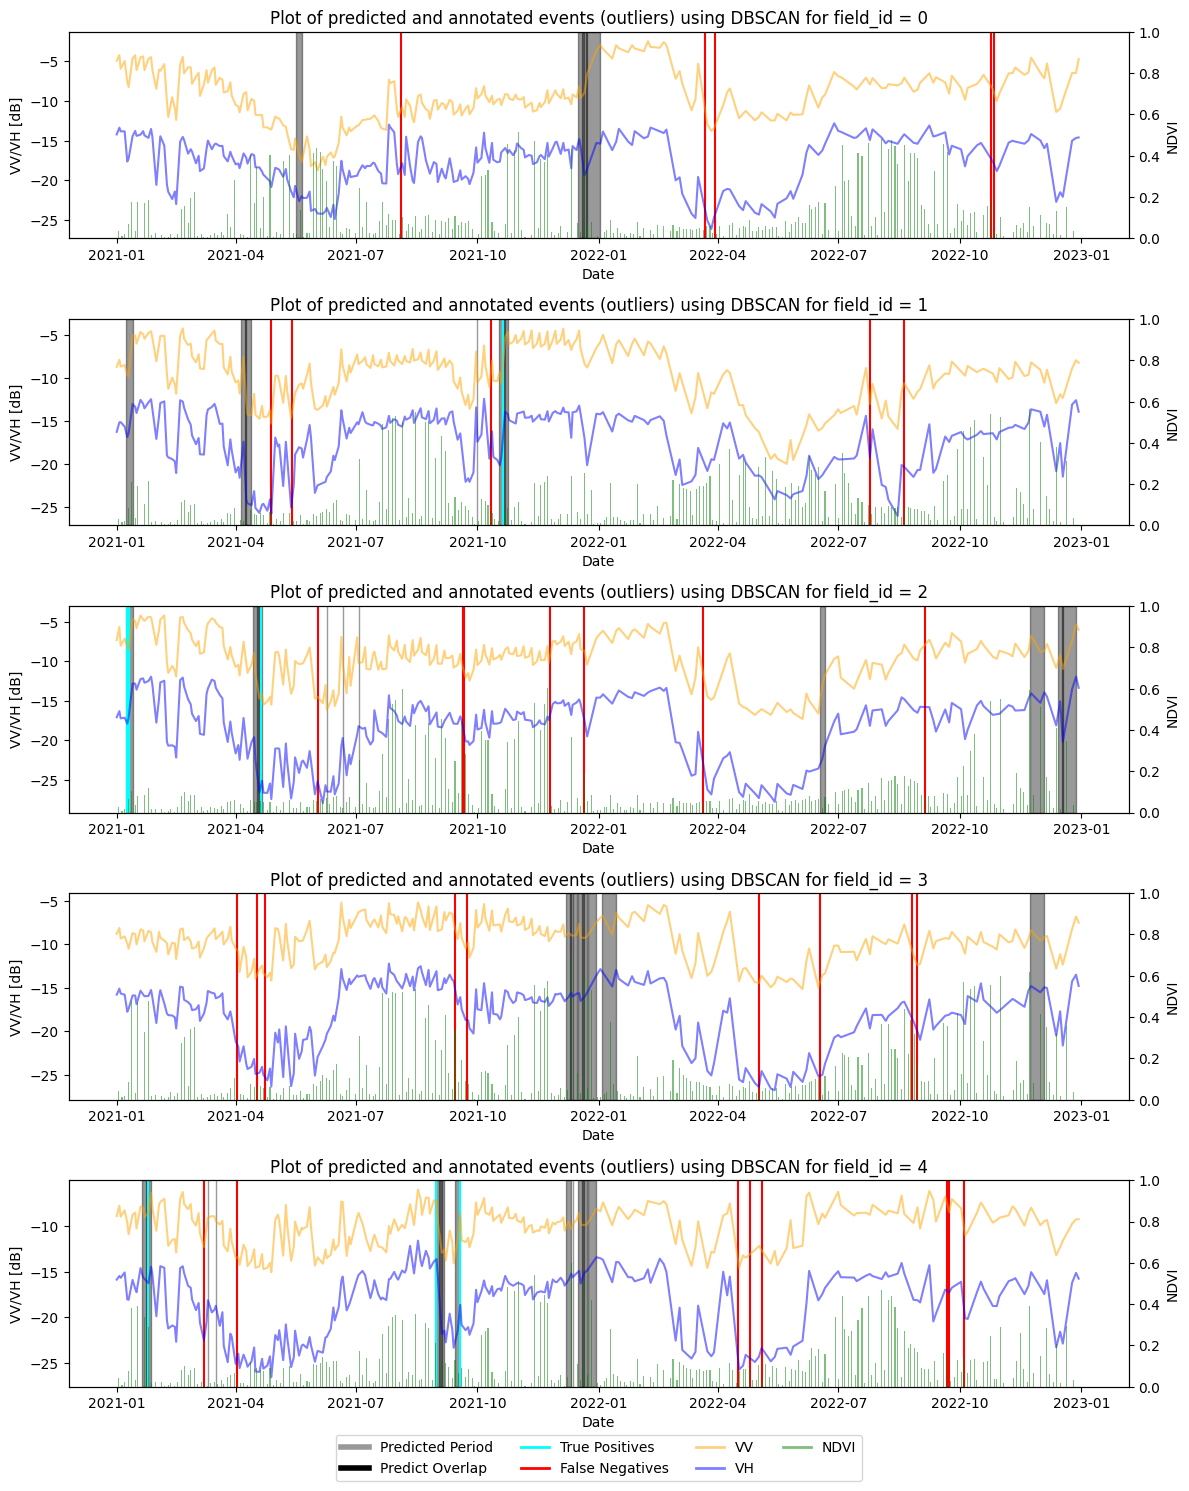

In [11]:
from matplotlib.lines import Line2D
from soil_roughness_change_detection.modules.preprocessor import preprocess_ndvi

ndvi_df = pd.read_pickle('./data/harrysfarm/harrysfarm_fields_ndvi.pkl').reset_index()
training_ndvi_df, testing_ndvi_df = preprocess_ndvi(
    ndvi_df,
    training_period_from=training_period_from,
    training_period_to=training_period_to,
    testing_period_from=training_period_to,
    testing_period_to=testing_period_to
)

with open(f'results/dbscan_test_result_feature.json', 'r') as f:
    obj = json.loads(f.read())
outlier_df = pd.DataFrame(obj[0]['outlier'])

fig, axes = plt.subplots(5, 1, figsize=(12, 3 * 5))
for field_id in range(5):
    ax2 = axes[field_id].twinx()

    outlier = outlier_df[outlier_df.id == field_id]
    outlier.loc[:, 'from_date'] = pd.to_datetime(outlier.from_date)
    outlier.loc[:, 'date'] = pd.to_datetime(outlier.date)
    for idx, row in outlier.iterrows():
        axes[field_id].axvspan(xmin=row.from_date, xmax=row.date, color='black', alpha=0.4)
    annotated_date = test_tillage_df.xs(field_id, level=1).index
    count = 0
    for d in annotated_date:
        check_df = outlier[(outlier.from_date <= d) & (outlier.date >= d)]
        if check_df.shape[0] > 0:
            count += 1
            axes[field_id].axvline(d, color='cyan')
        else:
            axes[field_id].axvline(d, color='red')
    data_df = testing_df.xs(field_id, level=1)
    vv_line = axes[field_id].plot(data_df.index, data_df.VV, alpha=0.5, label='VV', color='orange')
    vh_line = axes[field_id].plot(data_df.index, data_df.VH, alpha=0.5, label='VH', color='blue')
    plot_ndvi_df = testing_ndvi_df.xs(field_id, level=1)
    NDVI = plot_ndvi_df.NDVI
    # axes[field_id].plot(plot_ndvi_df.index, NDVI, color='green', alpha=0.5, label='NDVI')
    ax2.bar(plot_ndvi_df.index, NDVI, color='green', alpha=0.5, label='NDVI')
    axes[field_id].set_xlabel('Date')
    axes[field_id].set_title(f'Plot of predicted and annotated events (outliers) using DBSCAN for field_id = {field_id}')
    axes[field_id].set_ylabel('VV/VH [dB]')
    ax2.set_ylabel('NDVI')
    ax2.set_ylim([0, 1])
    # axes[field_id].set_ylim([0, data_df.VV.max() + 0.1])
    
    if field_id == 4:
        custom_legends = [
            Line2D([0], [0], color='black', alpha=0.4, lw=4),
            Line2D([0], [0], color='black', alpha=1, lw=4),
            Line2D([0], [0], color='cyan', lw=2),
            Line2D([0], [0], color='red', lw=2),
            Line2D([0], [0], color='orange', alpha=0.5, lw=2),
            Line2D([0], [0], color='blue', alpha=0.5, lw=2),
            Line2D([0], [0], color='green', alpha=0.5, lw=2)
        ]
        axes[field_id].legend(custom_legends, [
            'Predicted Period', 'Predict Overlap', 'True Positives', 'False Negatives', 'VV', 'VH', 'NDVI'
        ], loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4)
fig.tight_layout()

<>:39: SyntaxWarning: invalid escape sequence '\c'
<>:39: SyntaxWarning: invalid escape sequence '\c'
/var/folders/fh/b4cvq4qx0217_r1fsrg8v59w0000gn/T/ipykernel_15143/1481589446.py:39: SyntaxWarning: invalid escape sequence '\c'
  axes[field_id].set_title(f'Plot of predicted and annotated events (outliers) using Mahalanobis Distance with $\chi^2$ for field_id = {field_id}')


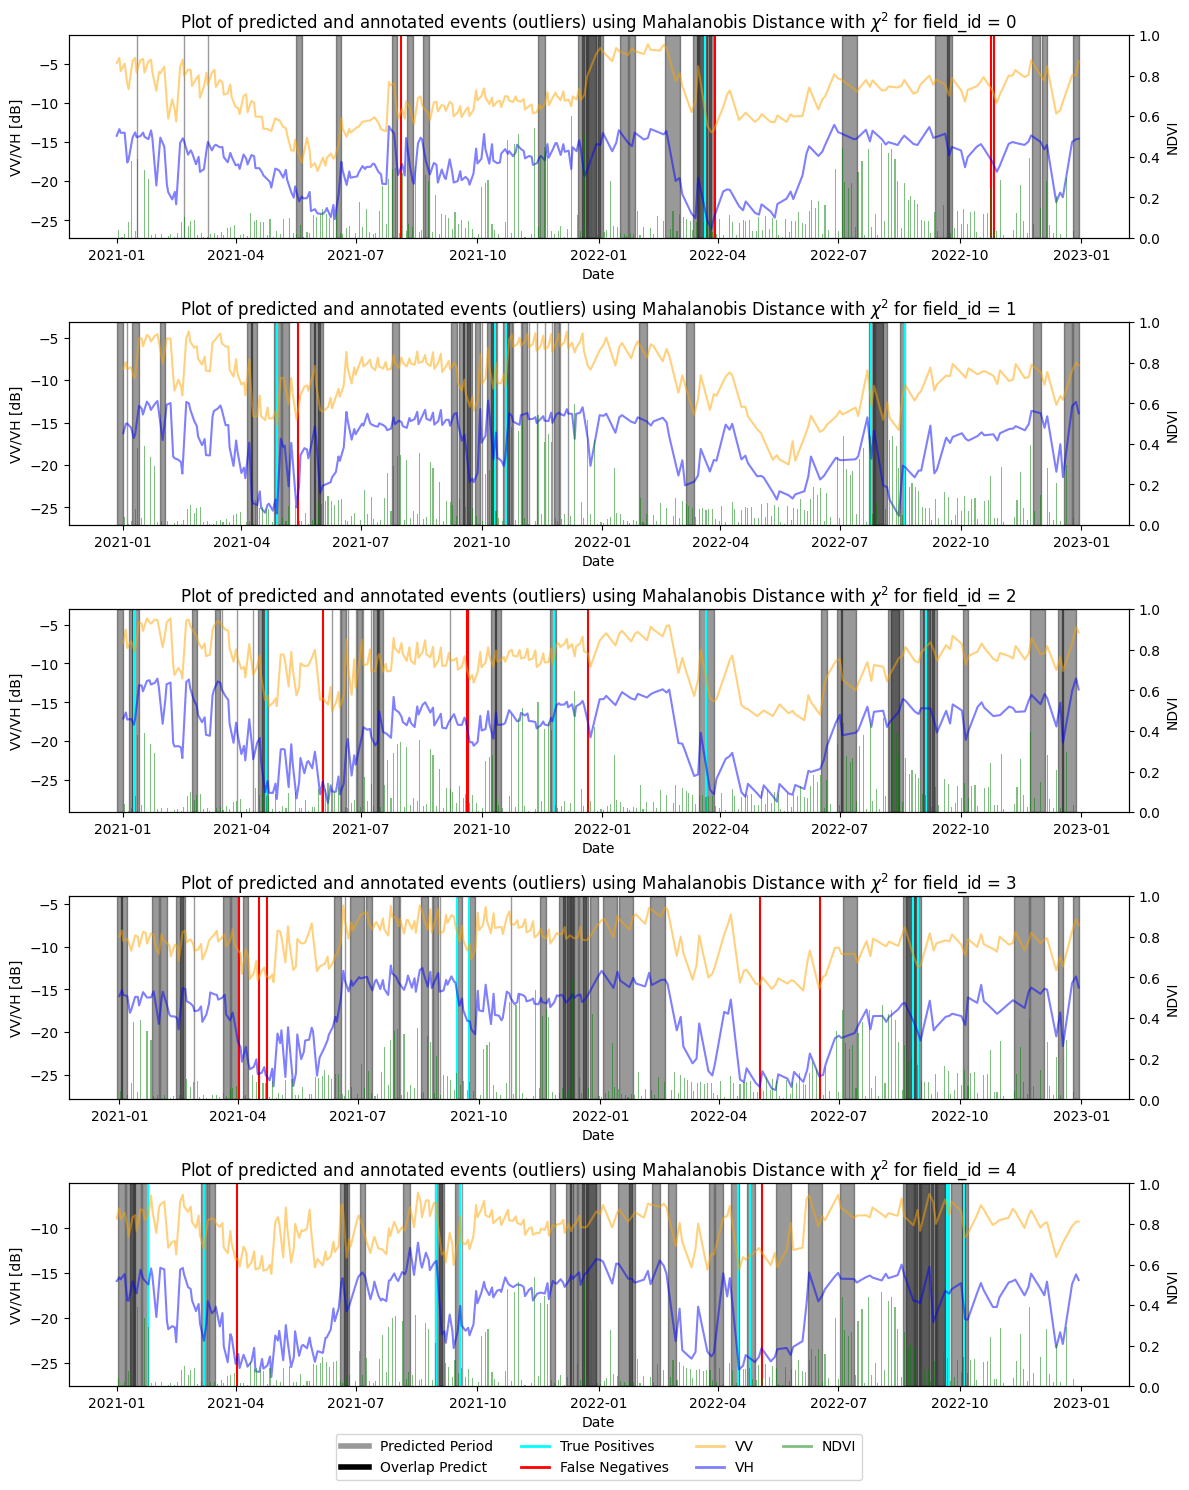

In [12]:
training_ndvi_df, testing_ndvi_df = preprocess_ndvi(
    ndvi_df,
    training_period_from=training_period_from,
    training_period_to=training_period_to,
    testing_period_from=training_period_to,
    testing_period_to=testing_period_to
)

with open(f'results/mahalanobis_test_result_feature.json', 'r') as f:
    obj = json.loads(f.read())
outlier_df = pd.DataFrame(obj[0]['outlier'])

fig, axes = plt.subplots(5, 1, figsize=(12, 3 * 5))
for field_id in range(5):
    ax2 = axes[field_id].twinx()

    outlier = outlier_df[outlier_df.id == field_id]
    outlier.loc[:, 'from_date'] = pd.to_datetime(outlier.from_date)
    outlier.loc[:, 'date'] = pd.to_datetime(outlier.date)
    for idx, row in outlier.iterrows():
        axes[field_id].axvspan(xmin=row.from_date, xmax=row.date, color='black', alpha=0.4)
    annotated_date = test_tillage_df.xs(field_id, level=1).index
    for d in annotated_date:
        check_df = outlier[(outlier.from_date <= d) & (outlier.date >= d)]
        if check_df.shape[0] > 0:
            count += 1
            axes[field_id].axvline(d, color='cyan')
        else:
            axes[field_id].axvline(d, color='red')

    data_df = testing_df.xs(field_id, level=1)
    vv_line = axes[field_id].plot(data_df.index, data_df.VV, alpha=0.5, label='VV', color='orange')
    vh_line = axes[field_id].plot(data_df.index, data_df.VH, alpha=0.5, label='VH', color='blue')
    # plot_ndvi_df = testing_ndvi_df.xs(field_id, level=1)
    NDVI = plot_ndvi_df.NDVI
    # axes[field_id].plot(plot_ndvi_df.index, NDVI, color='green', alpha=0.5, label='NDVI')
    ax2.bar(plot_ndvi_df.index, NDVI, color='green', alpha=0.5, label='NDVI')
    axes[field_id].set_xlabel('Date')
    axes[field_id].set_title(f'Plot of predicted and annotated events (outliers) using Mahalanobis Distance with $\chi^2$ for field_id = {field_id}')
    axes[field_id].set_ylabel('VV/VH [dB]')
    ax2.set_ylabel('NDVI')
    ax2.set_ylim([0, 1])
    
    if field_id == 4:
        custom_legends = [
            Line2D([0], [0], color='black', alpha=0.4, lw=4),
            Line2D([0], [0], color='black', alpha=1, lw=4),
            Line2D([0], [0], color='cyan', lw=2),
            Line2D([0], [0], color='red', lw=2),
            Line2D([0], [0], color='orange', alpha=0.5, lw=2),
            Line2D([0], [0], color='blue', alpha=0.5, lw=2),
            Line2D([0], [0], color='green', alpha=0.5, lw=2)
        ]
        axes[field_id].legend(custom_legends, [
            'Predicted Period', 'Overlap Predict', 'True Positives', 'False Negatives', 'VV', 'VH', 'NDVI'
        ], loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4)
fig.tight_layout()

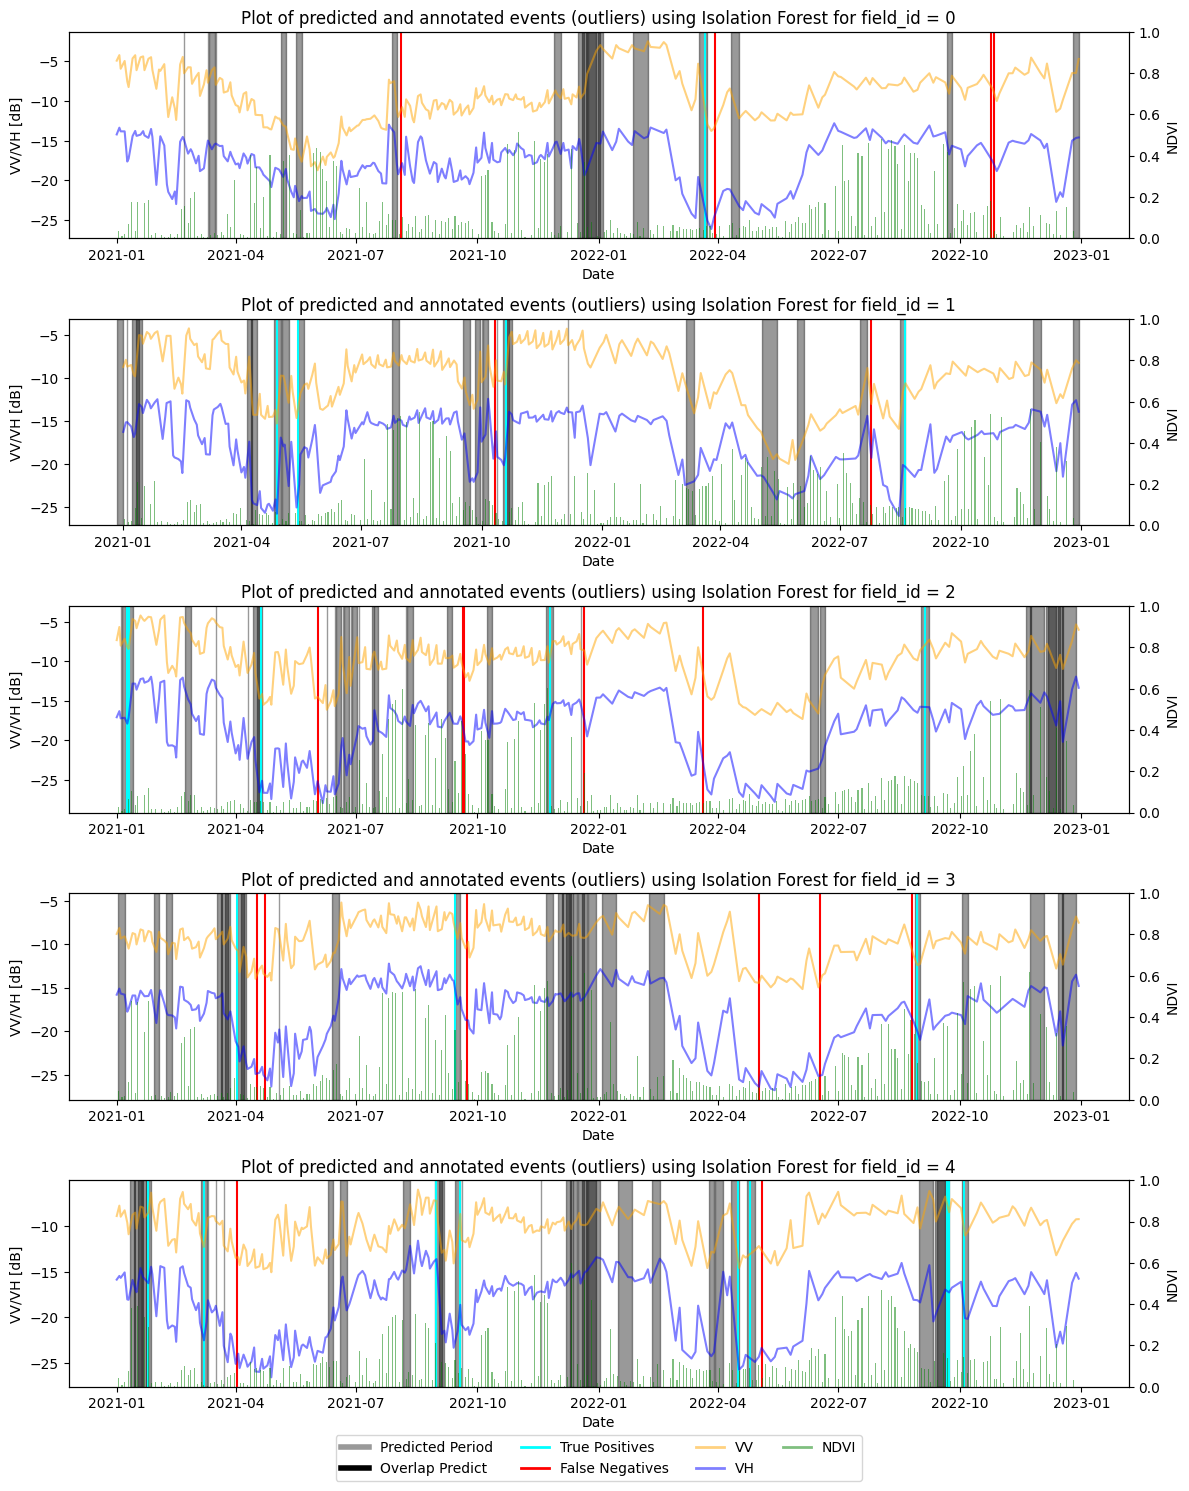

In [13]:
training_ndvi_df, testing_ndvi_df = preprocess_ndvi(
    ndvi_df,
    training_period_from=training_period_from,
    training_period_to=training_period_to,
    testing_period_from=training_period_to,
    testing_period_to=testing_period_to
)

with open(f'results/isolation_forest_test_result_feature.json', 'r') as f:
    obj = json.loads(f.read())
outlier_df = pd.DataFrame(obj[0]['outlier'])

fig, axes = plt.subplots(5, 1, figsize=(12, 3 * 5))
for field_id in range(5):
    ax2 = axes[field_id].twinx()
    outlier = outlier_df[outlier_df.id == field_id]
    outlier.loc[:, 'from_date'] = pd.to_datetime(outlier.from_date)
    outlier.loc[:, 'date'] = pd.to_datetime(outlier.date)
    for idx, row in outlier.iterrows():
        axes[field_id].axvspan(xmin=row.from_date, xmax=row.date, color='black', alpha=0.4)
    annotated_date = test_tillage_df.xs(field_id, level=1).index
    for d in annotated_date:
        check_df = outlier[(outlier.from_date <= d) & (outlier.date >= d)]
        if check_df.shape[0] > 0:
            count += 1
            axes[field_id].axvline(d, color='cyan')
        else:
            axes[field_id].axvline(d, color='red')

    data_df = testing_df.xs(field_id, level=1)
    vv_line = axes[field_id].plot(data_df.index, data_df.VV, alpha=0.5, label='VV', color='orange')
    vh_line = axes[field_id].plot(data_df.index, data_df.VH, alpha=0.5, label='VH', color='blue')
    plot_ndvi_df = testing_ndvi_df.xs(field_id, level=1)
    NDVI = plot_ndvi_df.NDVI
    ax2.bar(plot_ndvi_df.index, NDVI, color='green', alpha=0.5, label='NDVI')
    
    axes[field_id].set_xlabel('Date')
    axes[field_id].set_title(f'Plot of predicted and annotated events (outliers) using Isolation Forest for field_id = {field_id}')
    axes[field_id].set_ylabel('VV/VH [dB]')
    ax2.set_ylabel('NDVI')
    ax2.set_ylim([0, 1])
    
    if field_id == 4:
        custom_legends = [
            Line2D([0], [0], color='black', alpha=0.4, lw=4),
            Line2D([0], [0], color='black', alpha=1, lw=4),
            Line2D([0], [0], color='cyan', lw=2),
            Line2D([0], [0], color='red', lw=2),
            Line2D([0], [0], color='orange', alpha=0.5, lw=2),
            Line2D([0], [0], color='blue', alpha=0.5, lw=2),
            Line2D([0], [0], color='green', alpha=0.5, lw=2)
        ]
        axes[field_id].legend(custom_legends, [
            'Predicted Period', 'Overlap Predict', 'True Positives', 'False Negatives', 'VV', 'VH', 'NDVI'
        ], loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4)
fig.tight_layout()